In [61]:
import sys

import torch

sys.path.append("../")
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from lib.datasets import SyntheticPipelineDataset
from lib.models import HomogeneousGCN
from lib.pl import LightningModule
import matplotlib.pyplot as plt
import numpy as np

In [62]:
model = LightningModule.load_from_checkpoint(
    r"C:\Users\Konstantin\PycharmProjects\NIR\experiments\homogeneous_gcn\synthetic_pipeline_dataset\g3_8__m2_8__last_agg__clip__lr_0.001__edge_direction_undirected__\version_0\checkpoints\epoch=204-step=820.ckpt",
    model=HomogeneousGCN(
        in_channels=15,
        out_channels=1,
        gnn_num_layers=3,
        gnn_hidden_channels=8,
        mlp_num_layers=2,
        mlp_hidden_channels=8,
        aggregation="last",
        clip_output=(0., 1.)
    ),
    loss=F.mse_loss,
    lr=1e-3,
    )
model = model.eval()

In [63]:
dataset = SyntheticPipelineDataset(
        root=r"C:\Users\Konstantin\PycharmProjects\NIR\dataset\synthetic_pipeline_dataset",
        split="train",
        direction="undirected",
        dataset_len=5000,
        num_pipeline_node_types=15,
        max_pipeline_length=9,
        mode="offline",
    )
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [64]:
preds = []
gt = []
for batch in iter(loader):
    x, y = batch
    with torch.no_grad():
        pred = model.model(x).numpy()
    gt.append(y.numpy())
    preds.append(pred)

In [65]:
pred_metric = np.vstack(preds).reshape(-1)
metric = np.vstack(gt).reshape(-1)

In [66]:
pred_metric.shape, metric.shape

((3500,), (3500,))

In [67]:
mean_metric = np.mean(metric)
print("Mean metric: ", mean_metric)

Mean metric:  0.24915475


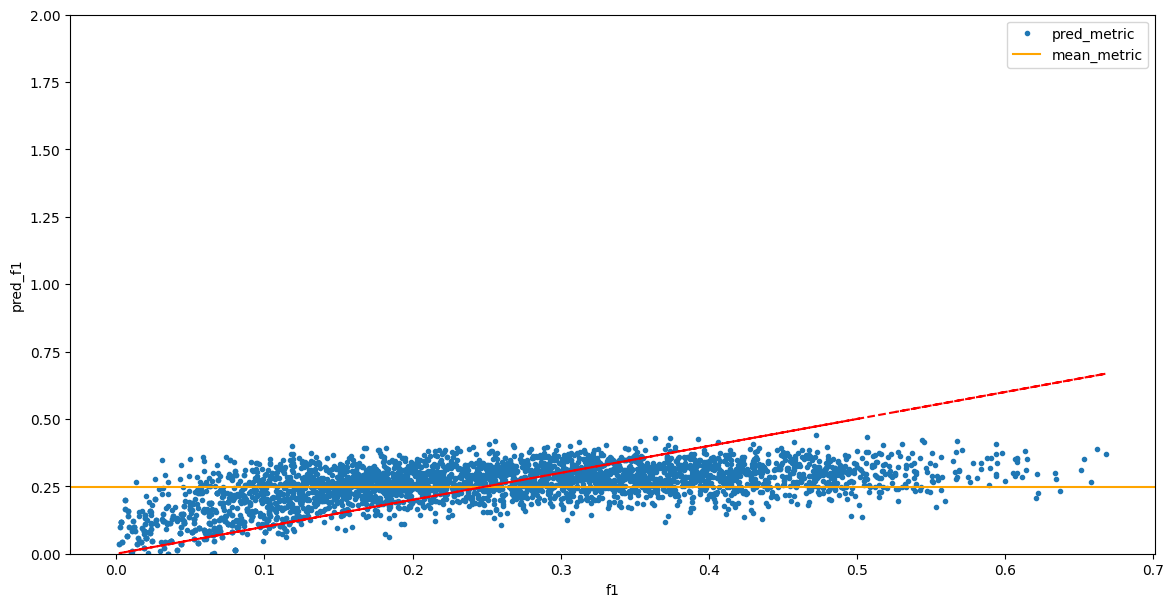

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(metric, pred_metric, ls="", marker=".", label="pred_metric")
ax.axhline(y=mean_metric, c="orange", label="mean_metric")
ax.plot(metric, metric, ls="--", c="red")
ax.set_xlabel("f1")
ax.set_ylabel("pred_f1")
ax.legend()
ax.set_ylim(0, 2)
plt.show()

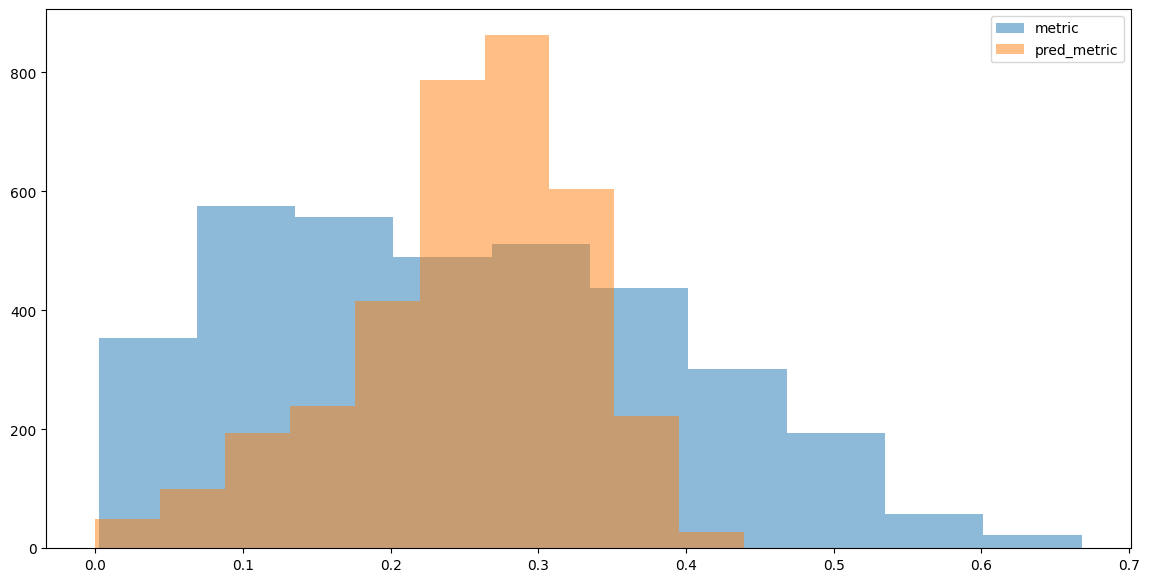

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.hist(metric, label="metric", alpha=0.5)
ax.hist(pred_metric, label="pred_metric", alpha=0.5)
ax.legend()
plt.show()

In [70]:
# Metric loss
print(F.mse_loss(torch.tensor(metric).reshape(-1, 1), torch.tensor(pred_metric).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(metric).reshape(-1, 1), torch.tensor([mean_metric] * len(metric)).reshape(-1, 1)))

tensor(0.0137)
tensor(0.0203)
